In [1]:
import os, joblib, json, numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import pandas as pd

In [2]:
#load the saved preprocessed data

project_root = r"C:/Graduation Project/AI_Cybersecurity"
processed_path = os.path.join(project_root, "Data", "Processed")

x_train = joblib.load(os.path.join(processed_path, "train_scaled.pkl"))
x_val = joblib.load(os.path.join(processed_path, "val_scaled.pkl"))
x_test = joblib.load(os.path.join(processed_path, "test_scaled.pkl"))
y_test = joblib.load(os.path.join(processed_path, "test_labels.pkl"))


x_train.shape, x_val.shape, x_test.shape

((1638568, 50), (409643, 50), (834347, 50))

In [3]:
# load scaler so that any new 
# traffic data (later) will be scaled 
# the exact same way as the trained data

scaler_path = os.path.join(processed_path, "scaler_cicids.pkl")

if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
else:
    scaler = None
    print("scaler not found")


In [4]:
# BUILD THE AUTOENCODER

# ensure same results every time
seed = 55
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


input_dim = 50  # one input neuron for each feature

input_layer = Input(shape=(input_dim,), name="ae_input")   #entry point

# ENCODER (compression)
enc = Dense(32, activation='relu' , name="enc_dense_32")(input_layer)    
enc = Dense(16, activation='relu' , name="enc_dense_16")(enc)
bottleneck = Dense(8, activation='relu' , name="bottleneck_8")(enc)
# each layer takes the previous layer's output and transforms it to a smaller number of neurons
# ,this compresses the information
# ,the final layer is the compressed version the encoder learns to use for reconstructing the data


# DECODER (reconstruction)
dec = Dense(16, activation='relu' , name="dec_dense_16")(bottleneck)
dec = Dense(32, activation='relu', name="dec_dense_32")(dec)

# these layers start reconstructing the data back to the original 50 dimension
# basically the encoder extracts patterns, decoder just rebuilds

output_layer = Dense(input_dim, activation='linear', name="ae_output")(dec)


autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_32 (Dense)            │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_16 (Dense)            │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_8 (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_16 (Dense)            │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_32 (Dense)            │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ae_output (Dense)               │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,634 (18.10 KB)

 Trainable params: 4,634 (18.10 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# TRAIN THE AUTOENCODER

history = autoencoder.fit(
    x_train, x_train,       # input = output bec autoencoder tries to reconstruct
    epochs=50,              # number of times the model sees all data
    batch_size=256,
    validation_data=(x_val, x_val)  #check reconstruction on validation set (no attacks)
)

Epoch 1/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0534 - val_loss: 0.0252
Epoch 2/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0227 - val_loss: 0.0212
Epoch 3/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0198 - val_loss: 0.0188
Epoch 4/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0182 - val_loss: 0.0177
Epoch 5/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0173 - val_loss: 0.0170
Epoch 6/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 7/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0161 - val_loss: 0.0157
Epoch 8/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0155 - val_loss: 0.0152
Epoch 9/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0148 - val_loss: 0.0146
Epoch 10/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 11/50
6401/6401 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 12/50
6401/6401 ━━━━━

In [6]:
# reconstruction error = how much the autoencoder failed to recreate the input

# get reconstructed outputs
train_pred = autoencoder.predict(x_train)
val_pred = autoencoder.predict(x_val)

# compute reconstruction error
train_mse = np.mean(np.square(x_train - train_pred), axis=1)
val_mse = np.mean(np.square(x_val - val_pred), axis=1)


51206/51206 ━━━━━━━━━━━━━━━━━━━━ 28s 537us/step
12802/12802 ━━━━━━━━━━━━━━━━━━━━ 7s 542us/step


In [7]:
# test on traffic with anomalies
# low error = normal behavior it understands
# high error = unusual behavior = anomaly

test_pred = autoencoder.predict(x_test)     # get reconstructed output of x+test

test_mse = np.mean(np.square(x_test - test_pred), axis=1)

train_mse[:10] , test_mse[:10]   #just to see examples

26074/26074 ━━━━━━━━━━━━━━━━━━━━ 14s 543us/step


(array([0.00053262, 0.01056093, 0.00365206, 0.00079569, 0.06508273,
        0.00452254, 0.00351939, 0.00116321, 0.04082706, 0.00129077]),
 array([0.00036138, 0.00117547, 0.00051918, 0.00051203, 0.00860672,
        0.00050753, 0.00024275, 0.01843938, 0.0005489 , 0.00761824]))

In [ ]:
# set anomaly threshold 
# and decide which reconstruction errors indicate anomalies

thresholds = np.linspace(min(test_mse), max(test_mse), 50)
best_f1 = 0
best_threshold = 0

for t in thresholds:
    y_pred_temp = (test_mse > t).astype(int)
    f1_temp = f1_score(y_test, y_pred_temp)
    if f1_temp > best_f1:
        best_f1 = f1_temp
        best_threshold = t

print("Anomaly threshold:", best_threshold)
print("Best F1-score:", best_f1)

Anomaly threshold: 0.00017488984832548496
Best F1-score: 0.6746419919780787


In [9]:
y_pred = (test_mse > best_threshold).astype(int)
print("Number of anomalies detected:", np.sum(y_pred))
print("Actual number of anomalies:", np.sum(y_test))


Number of anomalies detected: 834346
Actual number of anomalies: 424704.0


In [10]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)     #how many of the detected anomalies were actually attacks
print("Recall: ", recall)           #how many actual attacks were caught
print("F1-score; ", f1)
print("Confusion matrix:\n", cm)

Accuracy:  0.5090268197764239
Precision:  0.5090262313236954
Recall:  1.0
F1-score;  0.6746419919780787
Confusion matrix:
 [[     1 409642]
 [     0 424704]]


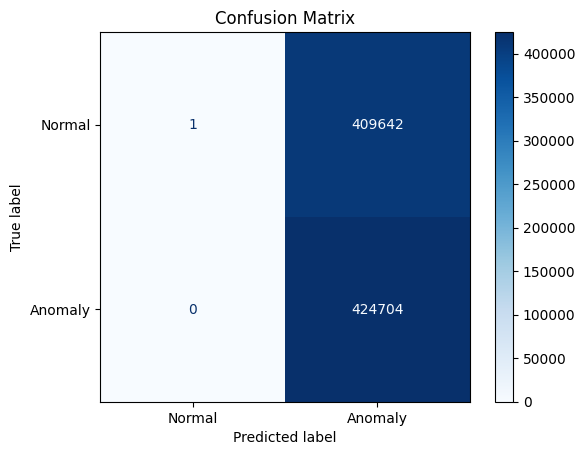

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues, values_format='d')  
plt.title("Confusion Matrix")
plt.show()


In [12]:
import joblib
import os

project_root = r"C:/Graduation Project/AI_Cybersecurity"
models_path = os.path.join(project_root, "Models")
os.makedirs(models_path, exist_ok=True)

joblib.dump(autoencoder, os.path.join(models_path, "ae_preds.pkl"))
autoencoder.save(os.path.join(models_path, "autoencoder.keras"))
joblib.dump(best_threshold, os.path.join(models_path, "ae_threshold.pkl"))


['C:/Graduation Project/AI_Cybersecurity\\Models\\ae_threshold.pkl']